# TopK benchmark

The notebook compares [onnxruntime](https://github.com/microsoft/onnxruntime) and [mlprodict](http://www.xavierdupre.fr/app/mlprodict/helpsphinx/index.html) implementation of operator [TopK](https://github.com/onnx/onnx/blob/master/docs/Operators.md#TopK).

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Plots

We measure two runtimes by computing a ratio between their time execution through the following kind of graphs.

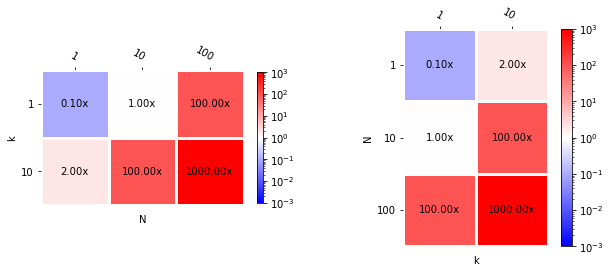

In [3]:
import matplotlib.pyplot as plt
from mlprodict.tools.plotting import plot_benchmark_metrics


def plot_metric(metric, ax=None, xlabel="N", ylabel="k", middle=1.,
                transpose=False, shrink=1.0, title=None):
    ax, cbar = plot_benchmark_metrics(metric, ax=ax, xlabel=xlabel, ylabel=ylabel,
                                      middle=middle, transpose=transpose,
                                      cbar_kw={'shrink': shrink})
    if title is not None:
        ax.set_title(title)
    return ax

    
data = {(1, 1): 0.1, (10, 1): 1, (1, 10): 2,
        (10, 10): 100, (100, 1): 100, (100, 10): 1000}

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_metric(data, ax[0], shrink=0.6)
plot_metric(data, ax[1], transpose=True);

## TopK in ONNX

The following lines creates an ONNX graph using one TopK ONNX node. The outcome is the ONNX graph converted into json.

In [4]:
import numpy
from numpy.random import randn
from skl2onnx.algebra.onnx_ops import OnnxTopK_11

X32 = randn(100000, 100).astype(numpy.float32)

node = OnnxTopK_11('X', numpy.array([5], dtype=numpy.int64),
                   output_names=['dist', 'ind'])

model_onnx = node.to_onnx([('X', X32)], target_opset=11,
                          # shape inference does not seem to work in onnxruntime
                          # so we speccify the output shape
                          outputs=[('dist', X32[:1, :5]),
                                   ('ind', X32[:1, :5].astype(numpy.int64))])
model_onnx

C:\xavierdupre\microsoft_github\sklearn-onnx\skl2onnx\common\_container.py:63: UserWarning: Unable to find an ONNX name in function 'apply_greater_or_equal', source=
def apply_greater_or_equal(scope, input_names, output_name, container, operator_name=None):
    _convert_compare_equal(scope, input_names, output_name, container, operator_name, 'GreaterEqual', 'Less', 'GreaterOrEqual')

  "'{0}', source=\n{1}".format(k, source))
C:\xavierdupre\microsoft_github\sklearn-onnx\skl2onnx\common\_container.py:63: UserWarning: Unable to find an ONNX name in function 'apply_less_or_equal', source=
def apply_less_or_equal(scope, input_names, output_name, container, operator_name=None):
    _convert_compare_equal(scope, input_names, output_name, container, operator_name, 'LessEqual', 'Greater', 'LessOrEqual')

  "'{0}', source=\n{1}".format(k, source))


ir_version: 6
producer_name: "skl2onnx"
producer_version: "1.6.9992"
domain: "ai.onnx"
model_version: 0
graph {
  node {
    input: "X"
    input: "To_TopKcst"
    output: "dist"
    output: "ind"
    name: "To_TopK"
    op_type: "TopK"
    domain: ""
  }
  name: "OnnxTopK_11"
  initializer {
    dims: 1
    data_type: 7
    int64_data: 5
    name: "To_TopKcst"
  }
  input {
    name: "X"
    type {
      tensor_type {
        elem_type: 1
        shape {
          dim {
          }
          dim {
            dim_value: 100
          }
        }
      }
    }
  }
  output {
    name: "dist"
    type {
      tensor_type {
        elem_type: 1
        shape {
          dim {
          }
          dim {
            dim_value: 5
          }
        }
      }
    }
  }
  output {
    name: "ind"
    type {
      tensor_type {
        elem_type: 7
        shape {
          dim {
          }
          dim {
            dim_value: 5
          }
        }
      }
    }
  }
}
opset_import {
  d

In [5]:
from mlprodict.onnxrt import OnnxInference
oinf = OnnxInference(model_onnx, runtime="python")
res = oinf.run({'X': X32})
dist, ind = res['dist'], res['ind']
dist[:2], ind[:2]

(array([[3.5322893, 1.8348566, 1.6429795, 1.589543 , 1.5079081],
        [2.951274 , 2.4692602, 2.2831876, 1.9420383, 1.7492594]],
       dtype=float32),
 array([[81, 86, 26, 60, 67],
        [15, 40, 71, 53, 70]], dtype=int64))

In [6]:
from mlprodict.tools import get_ir_version_from_onnx
model_onnx.ir_version = get_ir_version_from_onnx()

In [7]:
from onnxruntime import InferenceSession
sess = InferenceSession(model_onnx.SerializeToString())
dist, ind = sess.run(None, {'X': X32})
dist[:2], ind[:2]

(array([[3.5322893, 1.8348566, 1.6429795, 1.589543 , 1.5079081],
        [2.951274 , 2.4692602, 2.2831876, 1.9420383, 1.7492594]],
       dtype=float32),
 array([[81, 86, 26, 60, 67],
        [15, 40, 71, 53, 70]], dtype=int64))

Let's compare two implementations.

In [8]:
import numpy
import sklearn
from mlprodict.onnxrt.validate.validate_benchmark import benchmark_fct


def benchmark(X, fct1, fct2, N, repeat=10, number=10):

    def ti(n):
        if n <= 1:
            return 50
        if n <= 1000:
            return 2
        if n <= 10000:
            return 0.51
        return 0.11
    
    # to warm up the engine
    time_kwargs = {n: dict(repeat=10, number=10) for n in N[:2]}
    benchmark_fct(fct1, X, time_kwargs=time_kwargs, skip_long_test=False)
    benchmark_fct(fct2, X, time_kwargs=time_kwargs, skip_long_test=False)
    # real measure
    time_kwargs = {n: dict(repeat=int(repeat * ti(n)),
                           number=int(number * ti(n))) for n in N}
    res1 = benchmark_fct(fct1, X, time_kwargs=time_kwargs, skip_long_test=False)
    res2 = benchmark_fct(fct2, X, time_kwargs=time_kwargs, skip_long_test=False)

    res = {}
    for r in sorted(res1):
        r1 = res1[r]
        r2 = res2[r]
        ratio = r2['total'] / r1['total']
        res[r] = ratio
    return res


N = [1, 10, 100, 1000, 10000, 100000]
benchmark(X32, lambda x: sess.run(None, {'X': x}),
          lambda x: oinf.run({'X': x}), N=N)

{1: 1.1588407748039966,
 10: 0.9355504710826797,
 100: 0.34625060001953684,
 1000: 0.16080075993454876,
 10000: 0.13534567933366518,
 100000: 0.20759441149750366}

The implementation in [mlprodict](https://github.com/sdpython/mlprodict/blob/master/mlprodict/onnxrt/ops_cpu/_op_onnx_numpy.cpp#L246) is faster when the number of rows grows. It is faster for 1 rows, for many rows, the implementation uses openmp to parallelize.

## C++ implementation vs numpy

*scikit-learn* uses numpy to compute the top *k* elements.

In [9]:
from mlprodict.onnxrt.ops_cpu.op_topk import (
    topk_sorted_implementation, topk_sorted_implementation_cpp)

benchmark(X32, lambda x: topk_sorted_implementation(x, 5, 1, 0),
          lambda x: topk_sorted_implementation_cpp(x, 5, 1, 0), N=N)

{1: 0.3375204564791703,
 10: 0.36362526452939087,
 100: 0.29612839433016697,
 1000: 0.3085400101265125,
 10000: 0.17180440659081744,
 100000: 0.18984414756109644}

It seems to be faster too. Let's profile.


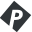

In [10]:
from pyquickhelper.pycode.profiling import profile
from IPython.display import HTML
xr = randn(1000000, 100)
HTML(profile(lambda: topk_sorted_implementation(xr, 5, 1, 0),
             pyinst_format='html')[1])

## Parallelisation

We need to disable the parallelisation to really compare both implementation.

In [11]:
from tqdm import tqdm


def benchmark_test(X, fct1, fct2, N, K, repeat=10, number=10):
    res = {}
    for k in tqdm(K):
        f1 = lambda x, k=k: fct1(x, k=k)
        f2 = lambda x, k=k: fct2(x, k=k)
        r = benchmark(X32, f1, f2, N=N, repeat=repeat, number=number)
        for n, v in r.items():
            res[n, k] = v
    return res


K = [1, 2, 5, 10, 15]
N = [1, 2, 3, 10, 100, 1000, 10000, 100000]

bench_para = benchmark_test(
    X32, (lambda x, k: topk_sorted_implementation_cpp(x, k=k, axis=1, largest=0, th_para=100000000)),
    (lambda x, k: topk_sorted_implementation_cpp(x, k=k, axis=1, largest=0, th_para=1)),
    N=N, K=K)

100%|██████████| 5/5 [00:27<00:00,  5.77s/it]


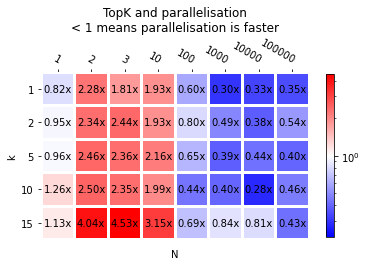

In [12]:
plot_metric(bench_para, transpose=False, title="TopK and parallelisation\n"
            "< 1 means parallelisation is faster", shrink=0.75);

This is somehow expected. First column is closed to 1 as it is the same code being compared. Next columns are red, meaning the parallelisation does not help, the parallelisation helps for bigger N, as least more than 100.

## Parallellisation with ONNX

We replicate the same experiment with an ONNX graph.

In [13]:
k_ = numpy.array([3], dtype=numpy.int64)
node = OnnxTopK_11('X', 'k',
                   output_names=['dist', 'ind'])

model_onnx = node.to_onnx([('X', X32), ('k', k_)], target_opset=11,
                          # shape inference does not seem to work in onnxruntime
                          # so we speccify the output shape
                          outputs=[('dist', X32[:1, :5]),
                                   ('ind', X32[:1, :5].astype(numpy.int64))])

In [14]:
oinf_no_para = OnnxInference(model_onnx, runtime="python")
res = oinf_no_para.run({'X': X32, 'k': k_})
dist, ind = res['dist'], res['ind']
dist[:2], ind[:2]

(array([[3.5322893, 1.8348566, 1.6429795],
        [2.951274 , 2.4692602, 2.2831876]], dtype=float32),
 array([[81, 86, 26],
        [15, 40, 71]], dtype=int64))

In [15]:
oinf_para = OnnxInference(model_onnx, runtime="python")
oinf_no_para.sequence_[0].ops_.th_para = 100000000
oinf_para.sequence_[0].ops_.th_para = 1

In [16]:
bench_onnx_para = benchmark_test(
    X32, (lambda x, k: oinf_no_para.run({'X': x, 'k': numpy.array([k], dtype=numpy.int64)})),
    (lambda x, k: oinf_para.run({'X': x, 'k': numpy.array([k], dtype=numpy.int64)})),
    N=N, K=K)

100%|██████████| 5/5 [00:56<00:00, 11.72s/it]


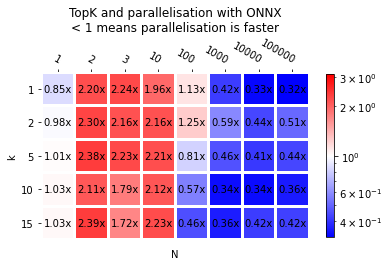

In [17]:
plot_metric(bench_onnx_para, transpose=False, title="TopK and parallelisation with ONNX\n"
            "< 1 means parallelisation is faster", shrink=0.75);

Pretty much the same results.

## onnxruntime vs mlprodict (no parallelisation)

In [18]:
model_onnx.ir_version = get_ir_version_from_onnx()
sess = InferenceSession(model_onnx.SerializeToString())

In [19]:
bench_ort = benchmark_test(
    X32, (lambda x, k: sess.run(None, {'X': x, 'k': numpy.array([k], dtype=numpy.int64)})),
    (lambda x, k: oinf_no_para.run({'X': x, 'k': numpy.array([k], dtype=numpy.int64)})),
    N=N, K=K)

100%|██████████| 5/5 [01:09<00:00, 14.73s/it]


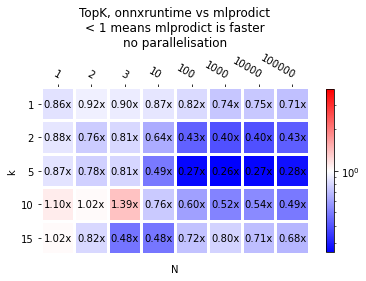

In [20]:
plot_metric(bench_ort, transpose=False, title="TopK, onnxruntime vs mlprodict\n"
            "< 1 means mlprodict is faster\nno parallelisation", shrink=0.75);

It seems the implement of operator TopK in onnxruntime 1.1.1 can be improved.

In [21]:
from onnxruntime import __version__ as ort_version
from mlprodict import __version__ as mlp_version
ort_version, mlp_version

('1.2.996', '0.3.1071')

And with parallelisation above 50 rows.

In [22]:
oinf_para.sequence_[0].ops_.th_para = 50
bench_ort_para = benchmark_test(
    X32, (lambda x, k: sess.run(None, {'X': x, 'k': numpy.array([k], dtype=numpy.int64)})),
    (lambda x, k: oinf_para.run({'X': x, 'k': numpy.array([k], dtype=numpy.int64)})),
    N=N, K=K)

100%|██████████| 5/5 [01:09<00:00, 14.11s/it]


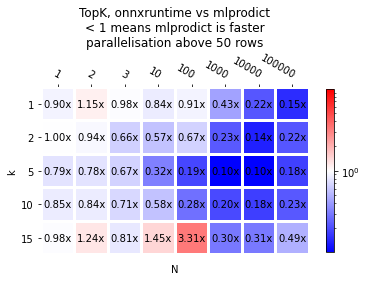

In [23]:
plot_metric(bench_ort_para, transpose=False, title="TopK, onnxruntime vs mlprodict\n"
            "< 1 means mlprodict is faster\nparallelisation above 50 rows", shrink=0.75);

Interesting...